# PetFinder.my - Pawpularity Contest
Date : 2021/09/23 ~ 2022/01/22

Start date : 2021/10/01 

Data : ID를 포함한 13개의 컬럼, 사진 메타데이터

Metric : RMSE(평균제곱근오차)

Questions Type : 예측(Prediction)

# Exploring

1. 사진을 제외한 데이터들을 이용하여 예측.
2. 사진과 데이터들을 같이 포함하여 예측.

1 : 데이터 분석 -> 데이터 정제 -> 예측
-> 상관관계 , 다중공선성등 변수끼리의 관계를 중점적으로 확인

2 : 1번 해결방식을 포함, 사진안에 어떠한 부분이 Pawpularity 점수에 

유의미한 영향을 끼치는지 확인(LIME)

-> 2DCNN 등등 

핵심 : 사진과 Binary 데이터들을 어떤식으로 조합하여 예측에 사용할지

# Exploratory Data Analysis

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [168]:

test_df = pd.read_csv('test.csv')
train_df = pd.read_csv('train.csv')

In [26]:
train_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [17]:
train_df.describe()

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
count,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000
mean,0.027643,0.772599,0.903955,0.861582,0.009988,0.067797,0.129338,0.049637,0.166263,0.172014,0.061239,0.070420,38.039044
std,0.163957,0.419175,0.294668,0.345356,0.099444,0.251409,0.335591,0.217204,0.372335,0.377411,0.239780,0.255866,20.591990
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000
50%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.000000
75%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,46.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000


In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9912 entries, 0 to 9911
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             9912 non-null   object
 1   Subject Focus  9912 non-null   int64 
 2   Eyes           9912 non-null   int64 
 3   Face           9912 non-null   int64 
 4   Near           9912 non-null   int64 
 5   Action         9912 non-null   int64 
 6   Accessory      9912 non-null   int64 
 7   Group          9912 non-null   int64 
 8   Collage        9912 non-null   int64 
 9   Human          9912 non-null   int64 
 10  Occlusion      9912 non-null   int64 
 11  Info           9912 non-null   int64 
 12  Blur           9912 non-null   int64 
 13  Pawpularity    9912 non-null   int64 
dtypes: int64(13), object(1)
memory usage: 1.1+ MB


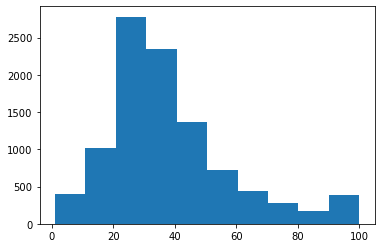

In [45]:
plt.hist(train_df['Pawpularity'])
plt.show()

# Pawpularity 점수를 구간별로 나눈뒤 해당 구간에 Binary 데이터들이
# 어떤식으로 분포되어있는지 안다면 예측에 좀더 용이하지 않을까?

독립변수들이 종속변수에 어떠한 영향을 주는지 확인 필요

독립변수는 명목척도, 종속변수는 등간척도기 때문에

ANOVA 분석 실시

ANOVA의 전제조건인 등분산성, 정규성, 독립성 검정 실시


In [99]:

# Paw_20 = train_df.loc[train_df['Pawpularity'] < 20]
# Paw_40 = train_df.loc[(train_df['Pawpularity'] < 40 ) & (train_df['Pawpularity']>=20)]
# Paw_60 = train_df.loc[(train_df['Pawpularity'] < 60 ) & (train_df['Pawpularity']>=40)]
# Paw_80 = train_df.loc[(train_df['Pawpularity'] < 80 ) & (train_df['Pawpularity']>=60)]
# Paw_100 = train_df.loc[(train_df['Pawpularity'] < 100 ) & (train_df['Pawpularity']>=80)]

In [123]:
y = train_df.Pawpularity
Test_df = train_df.iloc[:,1:-1]

In [124]:
Test_df

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
0,0,1,1,1,0,0,1,0,0,0,0,0
1,0,1,1,0,0,0,0,0,0,0,0,0
2,0,1,1,1,0,0,0,0,1,1,0,0
3,0,1,1,1,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9907,0,0,0,1,0,0,0,0,0,0,0,1
9908,0,1,1,1,0,0,0,0,0,0,0,0
9909,0,1,1,1,0,0,0,0,1,1,0,0
9910,0,1,1,1,0,0,0,0,1,0,0,0


독립성검정 실시. 명목척도이므로 카이제곱분석 실시

In [134]:
print('귀무가설 : 관련성이 없다')
print('대립가설 : 관련성이 있다')
check=[]
for i in Test_df.columns.tolist():
    result = pd.crosstab(Test_df[i],y)
    if stats.chi2_contingency(observed=result)[1] < 0.05:
        check.append('귀무가설 기각')
    else:
        check.append('귀무가설 지지')
result_df = pd.DataFrame(data = [Test_df.columns.tolist(),check]).T
result_df.columns = ['column','Hypothesis']
print(result_df)
        

귀무가설 : 관련성이 없다
대립가설 : 관련성이 있다
           column Hypothesis
0   Subject Focus    귀무가설 지지
1            Eyes    귀무가설 지지
2            Face    귀무가설 기각
3            Near    귀무가설 지지
4          Action    귀무가설 지지
5       Accessory    귀무가설 지지
6           Group    귀무가설 지지
7         Collage    귀무가설 지지
8           Human    귀무가설 지지
9       Occlusion    귀무가설 기각
10           Info    귀무가설 지지
11           Blur    귀무가설 지지


In [135]:
pd.crosstab(Test_df[i],y)

Pawpularity,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
Blur,,,,,,,,,,,,,,,,,,,,,
0,4,70,85,34,31,20,27,29,37,32,...,14,13,12,11,11,10,7,9,4,270
1,0,7,5,2,3,4,2,7,2,4,...,1,1,1,2,0,2,1,1,0,18


Anova분석의 전제조건인 독립성을 갖추기 위해 

p-value가 0.05 이상인 데이터들을 삭제

In [187]:
anova_df = train_df.iloc[:,1:].copy()
fail_hypo = ['Face','Occlusion']
anova_df.drop(anova_df[fail_hypo],axis=1,inplace=True)

정규성검정 실시

In [190]:
anova_df

,Subject Focus,Eyes,Near,Action,Accessory,Group,Collage,Human,Info,Blur,Pawpularity
0,0,1,1,0,0,1,0,0,0,0,63
1,0,1,0,0,0,0,0,0,0,0,42
2,0,1,1,0,0,0,0,1,0,0,28
3,0,1,1,0,0,0,0,0,0,0,15
4,0,0,1,0,0,1,0,0,0,0,72
...,...,...,...,...,...,...,...,...,...,...,...
9907,0,0,1,0,0,0,0,0,0,1,15
9908,0,1,1,0,0,0,0,0,0,0,70
9909,0,1,1,0,0,0,0,1,0,0,20
9910,0,1,1,0,0,0,0,1,0,0,20


In [136]:
# 종속변수가 많은 범위에 존재하다보니 제대로된 값이 나오지 않는것같음
# 0~49값을 귀엽지 않음으로, 50~100의 값을 귀여움으로 특정(0,1)하여 재분석
# -----------------------일단 무시

In [169]:
cute_df = train_df.copy()
cute_df['cute'] = 0
cute_df.loc[cute_df.Pawpularity<50,'cute'] = 0
cute_df.loc[(cute_df.Pawpularity<100) & (cute_df.Pawpularity >= 50),'cute'] = 1

In [174]:
cute_df.drop('Pawpularity',axis=1,inplace=True)


In [177]:
y = cute_df.cute
Test_df = cute_df.iloc[:,1:-1]

In [179]:
print('귀무가설 : 관련성이 없다')
print('대립가설 : 관련성이 있다')
check=[]
for i in Test_df.columns.tolist():
    result = pd.crosstab(Test_df[i],y)
    if stats.chi2_contingency(observed=result)[1] < 0.05:
        check.append('귀무가설 기각')
    else:
        check.append('귀무가설 지지')
result_df = pd.DataFrame(data = [Test_df.columns.tolist(),check]).T
result_df.columns = ['column','Hypothesis']
print(result_df)
        

귀무가설 : 관련성이 없다
대립가설 : 관련성이 있다
           column Hypothesis
0   Subject Focus    귀무가설 지지
1            Eyes    귀무가설 지지
2            Face    귀무가설 지지
3            Near    귀무가설 지지
4          Action    귀무가설 지지
5       Accessory    귀무가설 지지
6           Group    귀무가설 지지
7         Collage    귀무가설 지지
8           Human    귀무가설 지지
9       Occlusion    귀무가설 지지
10           Info    귀무가설 지지
11           Blur    귀무가설 지지


In [ ]:
내일 정규성검정하자
